In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
from tqdm import tqdm
from multiprocessing import Pool
from skimage.morphology import skeletonize
import skimage as ski
%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [ ]:
from network_flow_tracker import particle
from network_flow_tracker import LFBFP
from network_flow_tracker.utils import vis, stat, filters, graph, io
import network_flow_tracker.utils.image as im
import network_flow_tracker.utils.neighbors as nb

In [ ]:
data_root_path = '/net/birdstore/Vessel/Lightfield/Tube2025'
process_data_root = os.path.join(data_root_path, 'processed_data')
vis_folder = os.path.join(data_root_path, 'visualization')
info_fp = os.path.join(process_data_root, 'data_info.pickle')
update_info_Q = False

if not os.path.isfile(info_fp) or update_info_Q:
    data_info = {}
    data_info['frame_rate_Hz'] = 400
    data_info['voxel_size_um'] = np.array([2, 2, 2])
    data_info['target_voxel_size_um'] = 2
    data_info['bbox_mm'] = np.array([11, 10, 195])
    data_info['bbox_xx'] = np.array([46, 370, 225])
    data_info['bbox_ll'] = data_info['bbox_xx'] - data_info['bbox_mm']

    raw_data_root = os.path.join(data_root_path, 'raw_data')
    data_info['raw_data_folders'] = ['']
    data_info['num_z'] = len(data_info['raw_data_folders'])
    data_info['info_fp'] = info_fp
    data_info['raw_data_file'] = []
    data_info['num_files'] = []
    for fn in data_info['raw_data_folders']:
        fp = os.path.join(raw_data_root, fn)
        vol_list = sorted([f for f in os.listdir(fp) if f.endswith('.tif')])
        file_idx = [int(s.split('_')[1]) for s in vol_list]
        file_sort_idx = np.argsort(file_idx)
        new_file_list = [vol_list[i] for i in file_sort_idx]
        data_info['raw_data_file'].append(new_file_list)
        data_info['num_files'].append(len(new_file_list))
        print(f"Number of volume in the folder: {len(new_file_list)}")

    io.save_data(data_info['info_fp'], data_info)
else:
    print("Load from existing file")
    data_info = io.load_data(info_fp)

lfp = LFBFP.LFBFProcessing(data_root_path, data_info)
target_zoom = data_info['voxel_size_um'] / data_info['target_voxel_size_um']

Load from existing file


# Preprocessing data

### Visualize single volume

In [4]:
z_idx = 0
num_files = data_info['num_files'][z_idx]
z_folder_name = data_info['raw_data_folders'][z_idx]
lfp = LFBFP.LFBFProcessing(data_root_path, data_info)
t_idx = 0
test_data = lfp.load_and_preprocess_raw_data_to_match_mask(z_idx, t_idx)
test_data_e = im.stretch_contrast(test_data)

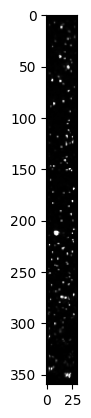

In [ ]:
f, a = plt.subplots()
a.imshow(test_data_e.max(axis=0), cmap='gray')
a.set_title(f"Z: {z_idx}, T: {t_idx} Max projection")

### Compute max intensity projection of the raw data

In [ ]:
def compute_mip_t(data_root_path, data_info, z_idx, save_folder=None):
    mip_stack = None
    mean_stack = None
    m2_stack = None
    num_files = data_info['num_files'][z_idx]
    z_folder_name = data_info['raw_data_folders'][z_idx]
    lfp = LFBFP.LFBFProcessing(data_root_path, data_info)
    for t_idx in range(num_files):
        raw_fp = lfp.fp_raw_data(z_idx, t_idx)
        raw_data = tiff.imread(raw_fp)
        if mip_stack is None: 
            mip_stack = raw_data
            mean_stack = raw_data.astype(np.float32)
            m2_stack = raw_data.astype(np.float32) ** 2
        else:
            mip_stack = np.maximum(mip_stack, raw_data)
            mean_stack += raw_data.astype(np.float32)
            m2_stack += raw_data.astype(np.float32) ** 2
        if t_idx % 50 == 0:
            print(f"Finish processing {t_idx/num_files} files")
    mean_stack /= num_files
    m2_stack /= num_files
    std_stack = np.sqrt(m2_stack - mean_stack ** 2) 
    if save_folder is not None: 
        fp_raw_mip = os.path.join(save_folder, f"{z_folder_name}_mip.tif")
        io.save_data(fp_raw_mip, mip_stack)
        fp_mean_mip = os.path.join(save_folder, f"{z_folder_name}_mean.tif")
        io.save_data(fp_mean_mip, mean_stack)
        fp_std_mip = os.path.join(save_folder, f"{z_folder_name}_std.tif")
        io.save_data(fp_std_mip, std_stack)
    return mip_stack

In [ ]:
fp_full_mip_folder = os.path.join(process_data_root, 'vol_t_stat', 'raw')
num_folder = len(data_info['raw_data_folders'])
args = [(data_root_path, data_info, z_idx, fp_full_mip_folder) for z_idx in range(num_folder)]
with Pool(int(num_folder)) as p: 
    result = p.starmap(compute_mip_t, args)
print("Finish computing all the task")

### Compute Bounding box

In [ ]:
mip_folder = os.path.join(process_data_root, 'raw_data_stat_stack')
mip_list = [io.load_data(os.path.join(mip_folder, 'raw_data_mip.tif'))]

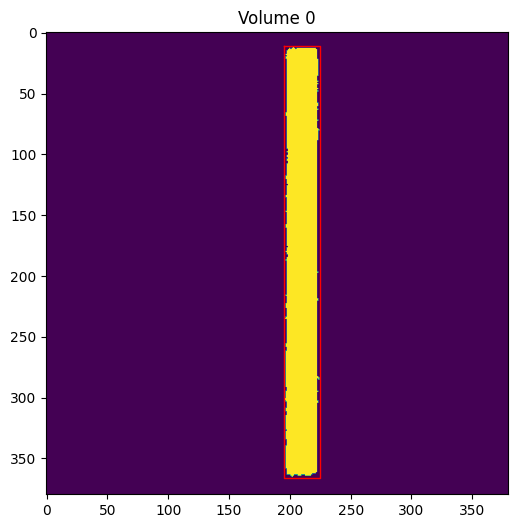

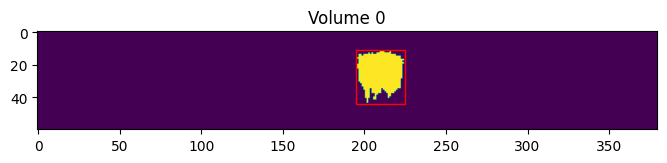

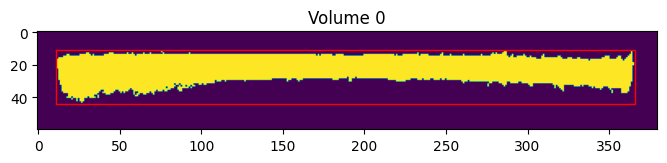

In [27]:
# Compute bounding box
bbox_on_axis = {}
for i_axis in range(3):
    vol_bbox = []
    for i_vol in range(len(mip_list)):
        tmp_mip2d = np.max(mip_list[i_vol], axis=i_axis)
        tmp_mask = tmp_mip2d > 2e2
        tmp_lm = ski.measure.label(tmp_mask)
        tmp_cc_prop = ski.measure.regionprops(tmp_lm)
        tmp_cc_num_pxl = np.array([p.num_pixels for p in tmp_cc_prop])
        tmp_is_large_cc_Q = tmp_cc_num_pxl > (np.sum(tmp_cc_num_pxl) * 0.3)
        large_cc_label = np.ravel_multi_index(np.where(tmp_is_large_cc_Q), tmp_is_large_cc_Q.shape) 
        tmp_large_cc_mask = np.zeros(tmp_lm.shape, dtype=bool)
        tmp_large_cc_bbox = []
        for i in list(large_cc_label):
            tmp_large_cc_mask |= (tmp_lm == (i + 1))
            tmp_large_cc_bbox.append(tmp_cc_prop[i].bbox)
        # Find the bounding box 
        tmp_lc_x, tmp_lc_y = np.nonzero(tmp_large_cc_mask)
        f, a = plt.subplots(figsize=(8, 6))
        a.imshow(tmp_large_cc_mask) 
        for bbox in tmp_large_cc_bbox:
            rr, cc = ski.draw.rectangle_perimeter((bbox[0], bbox[1]), end=(bbox[2] - 1, bbox[3] - 1), shape=tmp_large_cc_mask.shape)
            a.plot(cc, rr, 'r', linewidth=1)
        a.set_title(f"Volume {i_vol}")
        plt.show()
        vol_bbox.append(tmp_large_cc_bbox)
    
    bbox_on_axis[i_axis] = vol_bbox

In [28]:
bbox_on_axis

{0: [[(12, 196, 366, 225)]],
 1: [[(12, 196, 44, 225)]],
 2: [[(12, 12, 44, 366)]]}

In [ ]:
data_info['bbox_mm'] = np.array([11, 10, 195])
data_info['bbox_xx'] = np.array([46, 370, 225])
data_info['bbox_ll'] = data_info['bbox_xx'] - data_info['bbox_mm']
io.save_data(data_info['info_fp'], data_info)

# Particle detection

In [ ]:
tmp_stat = stat.compute_basic_statistics(mip_list[0].flatten().astype(np.float32))
tmp_stat['prctile_val']

array([0.0000000e+00, 1.0000000e+00, 3.0000000e+00, 9.0000000e+00,
       1.2000000e+01, 1.7000000e+01, 2.4000000e+01, 3.3000000e+01,
       4.4000000e+01, 5.3000000e+01, 7.5100000e+02, 1.4803001e+04,
       6.5535000e+04])

In [148]:
z_idx = 0
t_idx = 0
num_files = data_info['num_files'][z_idx]
z_folder_name = data_info['raw_data_folders'][z_idx]

In [ ]:
para = {}
para['dog_sig1'] = 0
para['dog_sig2'] = (2, 2, 2)
para['bg_vxl_f'] = 0.80
para['bg_est_sample_step'] = 10
para['min_peak_snr'] = 5
para['bg_max_int'] = 300
para['min_peak_dist'] = 3
para['peak_int_diff_sm_wd'] = 10
para['peak_int_diff_th'] = 1
para['nb_wd_r'] = (2, 2, 2)
para['nb_bg_min_dist'] = np.sqrt(5)

In [153]:
def dist_compute_single_stack_cell_positions(data_root_path, data_info, z_idx, t_idx, 
                                             para, overwrite_Q=False):
    lfp = LFBFP.LFBFProcessing(data_root_path, data_info)
    raw_fp = lfp.fp_raw_data(z_idx, t_idx)

    data = io.load_tiff(raw_fp, (data_info['bbox_mm'][0], data_info['bbox_xx'][0]))
    data = data[:, data_info['bbox_mm'][1]:data_info['bbox_xx'][1], 
                data_info['bbox_mm'][2]:data_info['bbox_xx'][2]]

    fp = lfp.fp_cell_pos(z_idx, t_idx)
    if os.path.isfile(fp) and not overwrite_Q:
        print(f"Load existing detected features from {fp}")
        nb_features = io.load_data(fp)
    else: 
        nb_features, log_stat = LFBFP.Detection.process_single_volume(data, para)
        data_info = {'para' : para, 'log' : log_stat, 'z' : z_idx, 't' : t_idx}
        nb_features['info'] = data_info
        io.save_data(fp, nb_features)
        print(f"Save detected features to {fp}")
    return nb_features

In [157]:
nb_features = dist_compute_single_stack_cell_positions(data_root_path, data_info,
                                        z_idx, 0, para, overwrite_Q=False)

Load existing detected features from /net/birdstore/Vessel/Lightfield/Tube2025/processed_data/cell_pos/recon_2_3d.h5


In [ ]:
args = [(data_root_path, data_info, z_idx, t_idx, para, False) for t_idx in range(data_info['num_files'][z_idx])]
with Pool(int(os.cpu_count()/2)) as p: 
    result = p.starmap(dist_compute_single_stack_cell_positions, args)
print("Finish computing all the task")   

In [158]:
min_snr = 5 
vis_Q = nb_features['peak_nb_snr'] > min_snr
vis_sub = (nb_features['pos'][vis_Q, 0], nb_features['pos'][vis_Q, 1], nb_features['pos'][vis_Q, 2])
vis_snr = nb_features['peak_nb_snr'][vis_Q]
print(f"Number of detected blobs of SNR > {min_snr}: {len(vis_snr)}")

Number of detected blobs of SNR > 5: 167


In [ ]:
data_mips = vis.compute_three_view_mip(data)
mip_c_min = 100
f, ax_yx, ax_yz, ax_zx, ax_blank = vis.vis_3_view_mip(data_mips, figsize=(4,8), aspect='auto', colorbarQ=False, cbar_label='Intensity', show_axes_Q=True, 
                                            fig_title=f"t = {t_idx} MIPs w pts", cmap='hot', visQ=False, 
                                            c_scale='log', v_min=mip_c_min)
ax_blank.set_visible(True)
sc = ax_yx.scatter(vis_sub[2], vis_sub[1], s=1, c=vis_snr, vmin=0, vmax=np.percentile(vis_snr, 95), cmap='winter')
sc = ax_yz.scatter(vis_sub[0], vis_sub[1], s=1, c=vis_snr, vmin=0, vmax=np.percentile(vis_snr, 95), cmap='winter')
sc = ax_zx.scatter(vis_sub[2], vis_sub[0], s=1, c=vis_snr, vmin=0, vmax=np.percentile(vis_snr, 95), cmap='winter')
f.colorbar(sc, cax=ax_blank, label='SNR')
plt.show()

# Graph construction

In [ ]:
mip_folder = os.path.join(process_data_root, 'raw_data_stat_stack')
v_mip_t = io.load_data(os.path.join(mip_folder, 'raw_data_mip.tif'))

v_mip_t = v_mip_t[data_info['bbox_mm'][0]:data_info['bbox_xx'][0], 
                  data_info['bbox_mm'][1]:data_info['bbox_xx'][1],
                  data_info['bbox_mm'][2]:data_info['bbox_xx'][2]]

In [190]:
# for each zx plane, find the centroid 
mip_yzx = np.transpose(v_mip_t, (1, 0, 2))
mip_yzx = filters.ndi.gaussian_filter(mip_yzx, sigma=(2, 2, 2))
mip_yzx = np.minimum(mip_yzx, 2e3)

In [ ]:
# compute the intensity centroid
skl_ctr = []
for i_zx in range(mip_yzx.shape[0]):
    tmp_im = mip_yzx[i_zx] 
    tmp_mask = tmp_im > 2e2
    tmp_i, tmp_j = np.nonzero(tmp_mask)
    tmp_int = tmp_im[tmp_i, tmp_j].astype(np.float32)
    tmp_i_avg = np.sum(tmp_i * tmp_int) / np.sum(tmp_int)
    tmp_j_avg = np.sum(tmp_j * tmp_int) / np.sum(tmp_int)
    skl_ctr.append([tmp_i.mean(), tmp_j.mean(), tmp_i_avg, tmp_j_avg])

skl_ctr = np.array(skl_ctr)

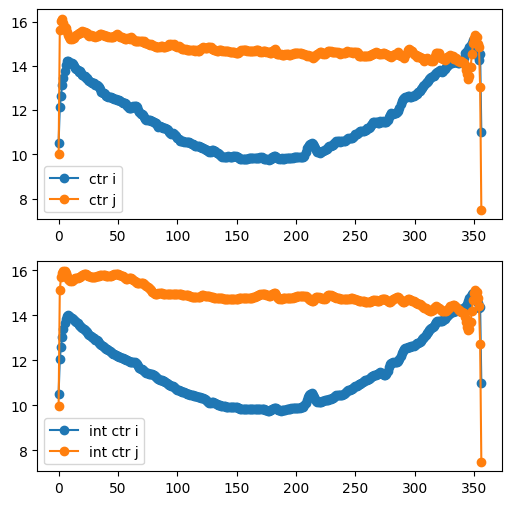

In [192]:
f, a = plt.subplots(2, 1, figsize=(6, 6))
a[0].plot(skl_ctr[:, 0], 'o-', label='ctr i')
a[0].plot(skl_ctr[:, 1], 'o-', label='ctr j')
a[1].plot(skl_ctr[:, 2], 'o-', label='int ctr i')
a[1].plot(skl_ctr[:, 3], 'o-', label='int ctr j')
a[0].legend()
a[1].legend()
plt.show()

In [198]:
ctr_zx = skl_ctr[:, 2:4]
ctr_valid_y = np.nonzero((ctr_zx[:, 0] > 0) & (ctr_zx[:, 1] > 0))[0]
ctr_zx = np.round(ctr_zx[ctr_valid_y]).astype(np.int32)
ctr_pos = np.column_stack((ctr_zx[:, 0], ctr_valid_y, ctr_zx[:, 1]))

In [290]:
ctr_mask = np.zeros(v_mip_t.shape, dtype=bool)
ctr_mask[ctr_pos[:, 0], ctr_pos[:, 1], ctr_pos[:, 2]] = True
# imclose w/ a line along y axis 
imc_elem = np.ones((3, 9, 3), dtype=bool)
ctr_mask_c = filters.ndi.binary_dilation(ctr_mask, structure=imc_elem)

In [300]:
ctr_mask_c = nb.bwareaopen(ctr_mask_c, min_size=100)
ctr_mask_skl = skeletonize(ctr_mask_c)

In [ ]:
# Skeleton to graph 
ctr_graph = graph.SpatialGraph(ctr_mask_skl)
ctr_ind = ctr_graph.edge.cc_ind[0]
ctr_sub = ctr_graph.edge.ind2sub(ctr_ind)
ctr_graph

This spatial graph does not contain a node connected component.


Spatial graph with 1 edges and 0 nodes.

In [332]:
sv_data = {}
sv_data['mask_size'] = ctr_mask_skl.shape
sv_data['skl_ind'] = ctr_ind
sv_data['skl_sub'] = ctr_sub
sv_data['skl_label_v'] = np.ones(len(ctr_ind), dtype=np.int32)
sv_data['im'] = v_mip_t
sv_data['label_array'] = v_mip_t > 2e2
sv_data['disp_vec'] = np.asarray([0, 0, 0])
sv_fp = os.path.join(process_data_root, 'skl', f"tube_skl.pickle")
io.save_data(sv_fp, sv_data)

In [ ]:
f, a = plt.subplots(figsize=(8, 6))
# plot 3d plot
a = plt.axes(projection='3d', elev=20, azim=-0)
a.scatter(ctr_sub[2], ctr_sub[1], ctr_sub[0])
a.set_xlabel('X')
a.set_ylabel('Y')
a.set_zlabel('Z')

# Tracking

In [ ]:
from network_flow_tracker import linking as NFTLinking
from network_flow_tracker import FlowGraph as FG
import pandas as pd
import skimage.morphology as skim
from network_flow_tracker.utils import util

In [8]:
sv_fp = os.path.join(process_data_root, 'skl', f"tube_skl.pickle")
sv_data = io.load_data(sv_fp)
v_mip_t = sv_data['im']
vis_mips = vis.compute_three_view_mip(v_mip_t)
skl_label_array = np.zeros(sv_data['mask_size'], dtype=np.int8)
skl_label_array.flat[sv_data['skl_ind']] = sv_data['skl_label_v']
fg = FG.FlowGraph(skl_label_array > 0)
fg.init_nearest_skl_map(vsl_skl_mask=skl_label_array)
fg

This spatial graph does not contain a node connected component.


Spatial graph with 1 edges and 0 nodes.

In [9]:
ctr_ind = fg.edge.cc_ind[0]
ctr_sub = fg.edge.ind2sub(ctr_ind)

In [10]:
z_idx = 0
mask_size = data_info['bbox_ll']
lfp = LFBFP.LFBFProcessing(data_root_path, data_info)
num_file = data_info['num_files'][z_idx]
# num_file = 500
# Load data
data_t_list = []
for t_idx in tqdm(range(num_file)):
    tmp_data = io.load_data(lfp.fp_cell_pos(z_idx, t_idx))
    tmp_df, tmp_info = NFTLinking.parse_detection_data(tmp_data, vol_shape=mask_size)
    data_t_list.append(tmp_df)
print("Finish loading cell position data")

  0%|          | 0/1999 [00:00<?, ?it/s]

100%|██████████| 1999/1999 [00:14<00:00, 138.62it/s]

Finish loading cell position data


In [11]:
# Select particles
max_dist_to_skl = 3
skl_cyl_mask = skim.binary_dilation(skl_label_array > 0, skim.ball(radius=max_dist_to_skl))

min_peak_snr = 5
mask_imc_r = 2
vsl_mask = sv_data['label_array'] > 0
non_bg_mask = skim.binary_closing(vsl_mask, skim.ball(radius=mask_imc_r))
# non_bg_mask = skl_cyl_mask

# Detection selection
detections = pd.concat(data_t_list).drop(columns=['sub_0', 'sub_1', 'sub_2', 'eig3', 'bg_std', 'nb_mean'])
detections = detections[detections.peak_nb_snr >= min_peak_snr]

in_mask_Q = non_bg_mask.flat[detections.ind.values]
detections = detections[in_mask_Q]

detections = detections.reset_index(drop=True)
# Add information
detections['skl_ind'] = fg.nearest_map.ind_to_nearest_ind(detections.ind.values)
detections['edge_label'] = fg.edge.ind_to_label(detections['skl_ind'].values)
detections['node_label'] = fg.node.ind_to_label(detections['skl_ind'].values)
# Define unique detection id 
detections['did'] = np.arange(detections.shape[0], dtype=np.int64)
print(f"Number of detections: {detections.shape[0]}")

Number of detections: 287782


In [12]:
lk_hdl = NFTLinking.Linking(detections, mask_size)

# Model free tracking at 400 Hz
Used for generating "ground truth" tracking result

In [ ]:
vxl2f_to_mm2s = data_info['target_voxel_size_um'] * data_info['frame_rate_Hz'] * 1e-3
vxl2f_to_mm2s

In [13]:
max_speed_pxl = 5
particle_key = 'particle'
min_len = 1

In [14]:
# naive tracking
fg.configure_trackpy_query(search_range=max_speed_pxl, num_nb=10, predictQ=False)
cv_trace_all = NFTLinking.tracking(detections, max_speed_pxl, pos_col=['z', 'y', 'x'], output_type='table')
cv_all_p_ind = LFBFP.Linking.select_long_trajectories_from_trackpy_result(cv_trace_all, min_len, sortedQ=0,
                            particle_key=particle_key, return_dict_Q=True)

# cv_trace = NFTLinking.tracking(active_detections, max_speed_pxl, pos_col=['z', 'y', 'x'], output_type='table')
# cv_p_ind = LFBFP.Linking.select_long_trajectories_from_trackpy_result(cv_trace, min_len, sortedQ=0,
#                             particle_key=particle_key, return_dict_Q=True)


Finish configuring trackpy query function.  {'search_range': 5, 'num_nb': 10, 'max_exit_travel': 0, 'predictQ': False, 'gdistQ': True, 'v_error_frac': 0.5, 'v_error_min': 5, 'compare_feature': [], 'feature_cost_max': 10}
Finish processing frame 1. 

Finish processing frame 1998. Finish tracking cells. 


In [ ]:
# cv_tracking_result = {
#     'max_speed_pxl': max_speed_pxl, 
#     'all_trace': cv_trace_all,
#     'all_p_ind': cv_all_p_ind,
#     'active_trace': cv_trace,
#     'active_p_ind': cv_p_ind
# }
# fp = os.path.join(process_data_root, 'linking', f"cv_tracking_results_max_speed_pxl_{max_speed_pxl}.pickle")
# io.save_data(fp, cv_tracking_result)
# print(f"Save tracking result to {fp}")

Save tracking result to /net/birdstore/Vessel/Lightfield/Tube2025/processed_data/linking/cv_tracking_results_max_speed_pxl_5.pickle


In [15]:
np.mean(np.isnan(cv_trace_all.alt_cost.values)), np.nanmean(cv_trace_all.alt_cost.values)

(0.8946285730170754, 4.2944207)

In [16]:
1 - np.mean(np.isnan(cv_trace_all.cost.values))

0.912628308928286

Finish saving figure as /net/birdstore/Vessel/Lightfield/Tube2025/visualization/Raw_detection_tracking_speed_distribution.pdf
Finish saving figure as /net/birdstore/Vessel/Lightfield/Tube2025/visualization/Raw_detection_tracking_speed_distribution.pickle
Finish saving figure as /net/birdstore/Vessel/Lightfield/Tube2025/visualization/Raw_detection_tracking_speed_distribution.png


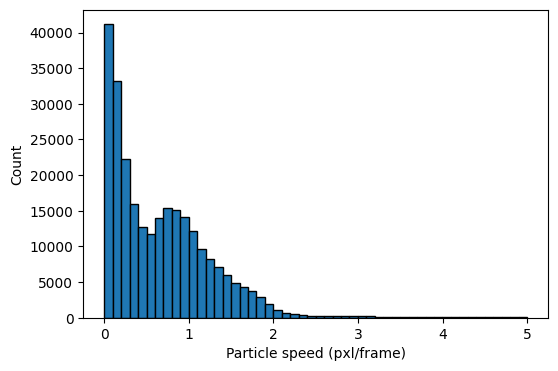

In [19]:
valid_p_speed = cv_trace_all.cost.values
valid_p_speed = valid_p_speed[~np.isnan(valid_p_speed)]
pre_select_speed_stat = stat.compute_basic_statistics(valid_p_speed.astype(np.float32))
f, a = plt.subplots(figsize=(6,4))
a.hist(valid_p_speed, bins=50, range=(0, valid_p_speed.max()), edgecolor='black')
a.set_xlabel('Particle speed (pxl/frame)')
a.set_ylabel('Count')

fig_fp = os.path.join(vis_folder, f"Raw_detection_tracking_speed_distribution.png")
io.print_image_in_several_formats(f, fig_fp)

Finish saving figure as /net/birdstore/Vessel/Lightfield/Tube2025/visualization/Raw_detection_tracking_speed_distribution_mm_per_s.pdf
Finish saving figure as /net/birdstore/Vessel/Lightfield/Tube2025/visualization/Raw_detection_tracking_speed_distribution_mm_per_s.pickle
Finish saving figure as /net/birdstore/Vessel/Lightfield/Tube2025/visualization/Raw_detection_tracking_speed_distribution_mm_per_s.png


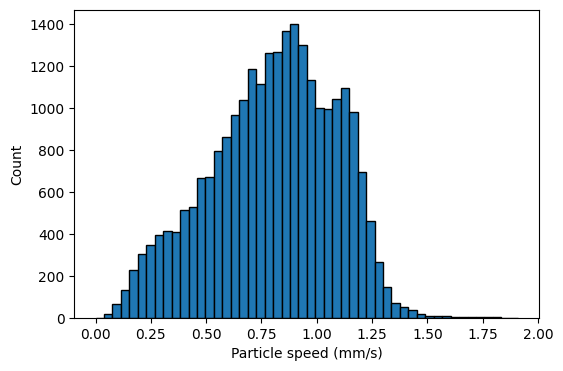

In [55]:
valid_p_speed_mm2s = valid_p_speed * vxl2f_to_mm2s
f, a = plt.subplots(figsize=(6,4))
a.hist(valid_p_speed_mm2s, bins=50, range=(0, valid_p_speed_mm2s.max()), edgecolor='black')
a.set_xlabel('Particle speed (mm/s)')
a.set_ylabel('Count')

fig_fp = os.path.join(vis_folder, f"Raw_detection_tracking_speed_distribution_mm_per_s.png")
io.print_image_in_several_formats(f, fig_fp)

In [20]:
pre_select_speed_stat['prctile_val'], pre_select_speed_stat['prctile_th']


(array([6.64173102e-04, 7.15484494e-03, 1.73674617e-02, 3.99506778e-02,
        6.61486253e-02, 1.69970974e-01, 5.51935226e-01, 1.01104179e+00,
        1.46091099e+00, 1.74538572e+00, 2.83631116e+00, 4.72437450e+00,
        4.99883652e+00]),
 array([  0. ,   0.1,   1. ,   5. ,  10. ,  25. ,  50. ,  75. ,  90. ,
         95. ,  99. ,  99.9, 100. ]))

In [21]:
max_dist_to_skl = 5
skl_cyl_mask = skim.binary_dilation(skl_label_array > 0, skim.ball(radius=max_dist_to_skl))
max_p_speed = 3 # flow in the tube should be relatively stable
min_cos = 0.5
min_length = 10
min_in_mask_frac = 0.5
valid_traces_ind = []
for i, tmp_idx in tqdm(cv_all_p_ind.items()):
    if tmp_idx.size >= min_length:
        tmp_p = particle.Particle(cv_trace_all.iloc[tmp_idx])
        tmp_in_mask_Q = skl_cyl_mask.flat[tmp_p.detections.ind.values]
        if np.mean(tmp_in_mask_Q) < min_in_mask_frac:
            continue
        tmp_adj_cos = tmp_p.cos_adj_disp_vec
        tmp_cos_mask = tmp_adj_cos >= min_cos
        tmp_v_mask = (tmp_p.v_norm <= max_p_speed)
        tmp_cos_mask = tmp_cos_mask & tmp_v_mask
        if not np.all(tmp_cos_mask):
            tmp_valid_ints = util.get_intervals_in_1d_binary_array(tmp_cos_mask)
            tmp_int_len = tmp_valid_ints[:, 1] - tmp_valid_ints[:, 0]
            for tmp_i_l, tmp_i_eps in zip(tmp_int_len, tmp_valid_ints):
                if tmp_i_l >= min_length:
                    valid_traces_ind.append(tmp_idx[tmp_i_eps[0]:tmp_i_eps[1]])
        else:
            valid_traces_ind.append(tmp_idx)

100%|██████████| 25144/25144 [00:03<00:00, 8051.81it/s]


In [22]:
len(valid_traces_ind)

792

In [ ]:
f = particle.vis_trajectory_with_mip(cv_trace_all, 
                                 valid_traces_ind[::5], 
                                 vis_mips['yx'], vis_method='line',
                                 figsize=(4, 20))

In [24]:
# construct new table
valid_trace_num_frame = [x.size for x in valid_traces_ind]
valid_p_id = np.repeat(np.arange(len(valid_traces_ind)), valid_trace_num_frame)
valid_detection = cv_trace_all.copy()
valid_detection = valid_detection.iloc[np.concatenate(valid_traces_ind)].reset_index(drop=True)
valid_detection.pid = valid_p_id
exit_Q = np.zeros(valid_detection.shape[0], dtype=bool)
exit_Q[np.asarray(valid_trace_num_frame).cumsum() - 1] = True
valid_detection['exit_Q'] = exit_Q
valid_detection.sort_values(by='frame', inplace=True)
valid_detection.did = np.arange(valid_detection.shape[0], dtype=np.int64)
valid_detection.reset_index(drop=True, inplace=True)

# valid_detect_fp = os.path.join(process_data_root, 'linking', f"cv_{max_speed_pxl}_selected_min_cos_{min_cos}_min_length_{min_length}_max_d2skl_{max_dist_to_skl}.pickle")
# io.save_data(valid_detect_fp, valid_detection)
# print(f"Saved valid detection to {valid_detect_fp}")


In [25]:
valid_detection.shape

(25823, 23)

Finish saving figure as /net/birdstore/Vessel/Lightfield/Tube2025/visualization/Selected_particle_speed_hist.pdf
Finish saving figure as /net/birdstore/Vessel/Lightfield/Tube2025/visualization/Selected_particle_speed_hist.pickle
Finish saving figure as /net/birdstore/Vessel/Lightfield/Tube2025/visualization/Selected_particle_speed_hist.png


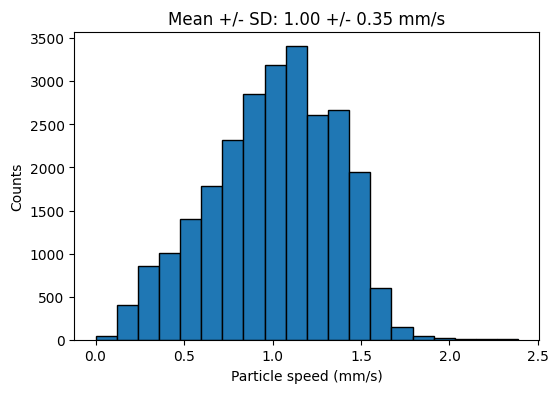

In [27]:
valid_p_speed = valid_detection.cost.values
valid_p_speed = valid_p_speed[~np.isnan(valid_p_speed)]
valid_p_speed = valid_p_speed[valid_p_speed < max_p_speed] * vxl2f_to_mm2s
valid_speed_stat = stat.compute_basic_statistics(valid_p_speed)
f, a = plt.subplots(figsize=(6,4))
a.hist(valid_p_speed, bins=20, range=(0, valid_p_speed.max()), edgecolor='black')
a.set_xlabel('Particle speed (mm/s)')
a.set_ylabel('Counts')
a.set_title(f"Mean +/- SD: {valid_speed_stat['mean']:.2f} +/- {valid_speed_stat['std']:.2f} mm/s")
fig_fp = os.path.join(vis_folder, f"Selected_particle_speed_hist.png")
io.print_image_in_several_formats(f, fig_fp)


In [56]:
np.mean(valid_p_speed <= 2)

0.9990909090909091

In [28]:
valid_detection.shape

(25823, 23)

# Compare tracking algorithms

In [29]:
valid_detect_list = util.split_table_by_key(valid_detection, split_key='frame')

In [30]:
valid_detect_pdist_stat = []
for tmp_data in valid_detect_list: 
    if isinstance(tmp_data, list): 
        tmp_xyz = np.empty((0, 3), dtype=float)
    else:
        tmp_xyz = tmp_data[['x', 'y', 'z']].to_numpy()
        # compute pairwise distances
        tmp_pdist = np.sqrt(np.sum((tmp_xyz[None, :, :] - tmp_xyz[:, None, :]) ** 2, axis=-1))
        tmp_pdist[np.eye(tmp_pdist.shape[0], dtype=bool)] = np.inf
        tmp_min_dist = np.min(tmp_pdist, axis=1)
        tmp_stat = stat.compute_basic_statistics(tmp_min_dist)
        valid_detect_pdist_stat.append(tmp_stat)

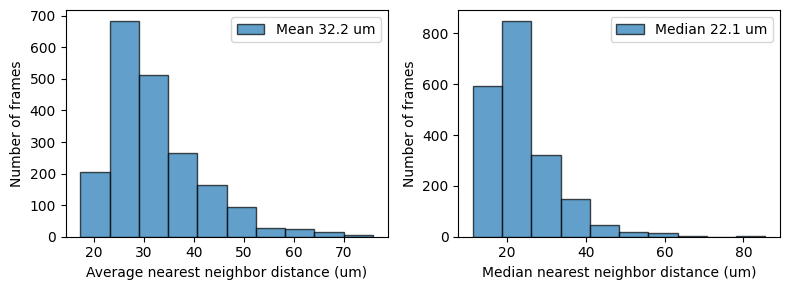

Finish saving figure as /net/birdstore/Vessel/Lightfield/Tube2025/visualization/Selected_particle_nearest_neighbor_distance_hist.pdf
Finish saving figure as /net/birdstore/Vessel/Lightfield/Tube2025/visualization/Selected_particle_nearest_neighbor_distance_hist.pickle
Finish saving figure as /net/birdstore/Vessel/Lightfield/Tube2025/visualization/Selected_particle_nearest_neighbor_distance_hist.png


In [32]:
avg_min_dist = np.asarray([s['mean'] for s in valid_detect_pdist_stat]) * data_info['target_voxel_size_um']
med_min_dist = np.asarray([s['median'] for s in valid_detect_pdist_stat]) * data_info['target_voxel_size_um']
f, a = plt.subplots(1, 2, figsize=(8, 3))
a[0].hist(avg_min_dist, bins=10, label=f'Mean {avg_min_dist.mean():.1f} um', alpha=0.7, edgecolor='black')
a[1].hist(med_min_dist, bins=10, label=f'Median {np.median(med_min_dist):.1f} um', alpha=0.7, edgecolor='black')
a[0].legend(loc='upper right')
a[1].legend(loc='upper right')
a[0].set_xlabel('Average nearest neighbor distance (um)')
a[1].set_xlabel('Median nearest neighbor distance (um)')
a[0].set_ylabel('Number of frames')
a[1].set_ylabel('Number of frames')
plt.tight_layout()
plt.show()

fig_fp = os.path.join(vis_folder, f"Selected_particle_nearest_neighbor_distance_hist.png")
io.print_image_in_several_formats(f, fig_fp)

In [33]:
print(f"Median mean min dist: {np.nanmedian(avg_min_dist):.2f} pxl")
print(f"Median median min dist: {np.nanmedian(med_min_dist):.2f} pxl")

Median mean min dist: 29.94 pxl
Median median min dist: 22.14 pxl


In [34]:
np.percentile(med_min_dist, [25, 50, 75])

array([17.98572185, 22.13609856, 27.00995958])

### Generate test dataset by subsampling

In [ ]:
from network_flow_tracker.evaluation import TraceGenerator

In [48]:
init_default_id = -1
normal_exit_id = -2
abnormal_exit_id = -3
est_v_0 = 2
sample_step = 20
est_v = est_v_0 * sample_step
effective_frame_rate_Hz = data_info['frame_rate_Hz'] / sample_step
print(f"Effective frame rate: {effective_frame_rate_Hz} Hz")
sampled_detection = []
for i, j in enumerate(range(0, len(valid_detect_list), sample_step)):
    tmp_data = valid_detect_list[j].copy()
    tmp_data.frame = i
    sampled_detection.append(tmp_data)

sampled_detection = pd.concat(sampled_detection).reset_index(drop=True)
sampled_detection.did = np.arange(sampled_detection.shape[0], dtype=np.int64)
gt_link_target = TraceGenerator.detection_table_to_link_idx(sampled_detection,
                             init_default_id, normal_exit_id, abnormal_exit_id)

test_detections = sampled_detection.drop(columns=['pid', 'particle', 'cost', 'alt_cost', 
                                                  'num_cands', 'exit_ind', 'dist_to_ep', 
                                                  'exit_v', 'exit_Q'])

Effective frame rate: 20.0 Hz


### Naive tracking

In [52]:
cv_speed_list = [5, 10, 15, 20, 25, 30, 40, 50, 60]
cv_stat_list = []
for cv_max_speed in cv_speed_list:    
    # max_speed_pxl = 30
    # naive tracking
    fg.configure_trackpy_query(search_range=cv_max_speed, num_nb=10, predictQ=False)
    cv_trace = NFTLinking.tracking(test_detections, cv_max_speed, pos_col=['z', 'y', 'x'], output_type='table')
    cv_stat, cv_link_target = TraceGenerator.analyze_tracking_result(cv_trace, gt_link_target)
    cv_stat_list.append(cv_stat['stat'])

cv_stat_list = util.list_of_dict_to_dict_of_array(cv_stat_list)

Finish configuring trackpy query function.  {'search_range': 5, 'num_nb': 10, 'max_exit_travel': 0, 'predictQ': False, 'gdistQ': True, 'v_error_frac': 0.5, 'v_error_min': 5, 'compare_feature': [], 'feature_cost_max': 10}
Finish processing frame 20. 

Finish processing frame 99. Finish tracking cells. 
Finish configuring trackpy query function.  {'search_range': 10, 'num_nb': 10, 'max_exit_travel': 0, 'predictQ': False, 'gdistQ': True, 'v_error_frac': 0.5, 'v_error_min': 5, 'compare_feature': [], 'feature_cost_max': 10}
Finish processing frame 99. Finish tracking cells. 
Finish configuring trackpy query function.  {'search_range': 15, 'num_nb': 10, 'max_exit_travel': 0, 'predictQ': False, 'gdistQ': True, 'v_error_frac': 0.5, 'v_error_min': 5, 'compare_feature': [], 'feature_cost_max': 10}
Finish processing frame 99. Finish tracking cells. 
Finish configuring trackpy query function.  {'search_range': 20, 'num_nb': 10, 'max_exit_travel': 0, 'predictQ': False, 'gdistQ': True, 'v_error_frac': 0.5, 'v_error_min': 5, 'compare_feature': [], 'feature_cost_max': 10}
Finish processing frame 99. Finish tracking cells. 
Finish configuring trackpy query function.  {'search_range': 25, 'num_nb': 10, 'max_exit_travel': 0, 'predictQ': False, 'gdist

Finish saving figure as /net/birdstore/Vessel/Lightfield/Tube2025/visualization/CV_ds_step_20_performance_vs_max_speed_vxl.pdf
Finish saving figure as /net/birdstore/Vessel/Lightfield/Tube2025/visualization/CV_ds_step_20_performance_vs_max_speed_vxl.pickle
Finish saving figure as /net/birdstore/Vessel/Lightfield/Tube2025/visualization/CV_ds_step_20_performance_vs_max_speed_vxl.png


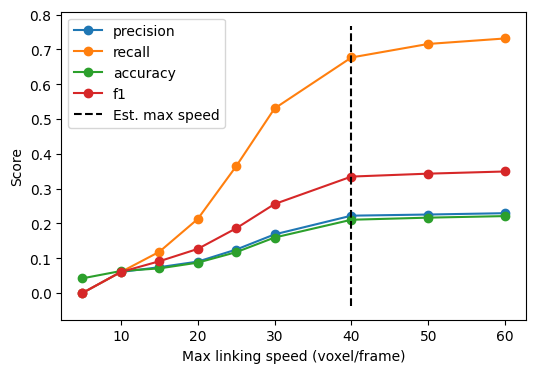

In [53]:
f, a = plt.subplots(1, 1, figsize=(6,4))
for i, stat_name in enumerate(['precision', 'recall', 'accuracy', 'f1']):
    a.plot(cv_speed_list, cv_stat_list[stat_name], 'o-', label=stat_name)

a.vlines(x=est_v, color='k', linestyle='--', ymin=a.get_ylim()[0], ymax=a.get_ylim()[1], label='Est. max speed')
a.set_xlabel('Max linking speed (voxel/frame)')
a.set_ylabel('Score')
a.legend()
fig_fp = os.path.join(vis_folder, f"CV_ds_step_{sample_step}_performance_vs_max_speed_vxl.png")
io.print_image_in_several_formats(f, fig_fp)

Finish saving figure as /net/birdstore/Vessel/Lightfield/Tube2025/visualization/CV_ds_step_20_performance_vs_max_speed_mm_s.pdf
Finish saving figure as /net/birdstore/Vessel/Lightfield/Tube2025/visualization/CV_ds_step_20_performance_vs_max_speed_mm_s.pickle
Finish saving figure as /net/birdstore/Vessel/Lightfield/Tube2025/visualization/CV_ds_step_20_performance_vs_max_speed_mm_s.png


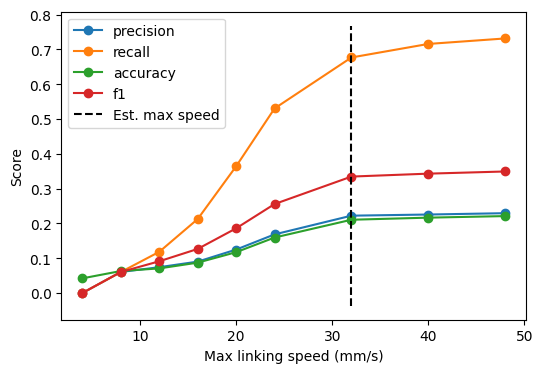

In [54]:
f, a = plt.subplots(1, 1, figsize=(6,4))
for i, stat_name in enumerate(['precision', 'recall', 'accuracy', 'f1']):
    a.plot(np.asarray(cv_speed_list) * vxl2f_to_mm2s, cv_stat_list[stat_name], 'o-', label=stat_name)

a.vlines(x=est_v * vxl2f_to_mm2s, color='k', linestyle='--', ymin=a.get_ylim()[0], ymax=a.get_ylim()[1], label='Est. max speed')
a.set_xlabel('Max linking speed (mm/s)')
a.set_ylabel('Score')
a.legend()

fig_fp = os.path.join(vis_folder, f"CV_ds_step_{sample_step}_performance_vs_max_speed_mm_s.png")
io.print_image_in_several_formats(f, fig_fp)

### Edge-based analysis

In [ ]:
test_ef_old = fg.get_edgeflow_object(0, detection_in_edge=test_detections)
dm_info_old = test_ef_old.iterative_est_avg_velocity_from_detection_map(test_ef_old.detect_map, 
    init_bin_size=2, init_dt=1, min_peak_corr=0.05, min_num_div=3,
    max_num_div=40, re_est_min_tot_cor_r=3, max_dt=128, vis_Q=True)

Text(0, 0.5, 'X')

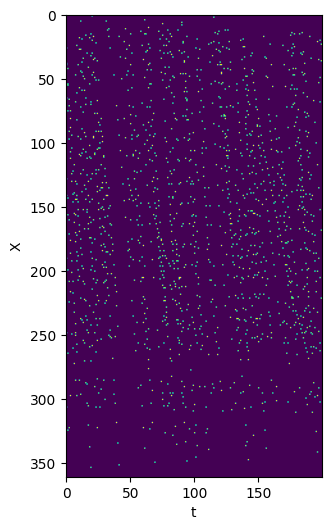

In [30]:
f, a = plt.subplots(figsize=(8, 6))
a.imshow(test_ef_old.detect_map.T)
a.set_xlabel('t')
a.set_ylabel('X')

In [31]:
test_ef_old = fg.get_edgeflow_object(0, detection_in_edge=sampled_detection)
dm_info_old = test_ef_old.iterative_est_avg_velocity_from_detection_map(test_ef_old.detect_map, 
    init_bin_size=2, init_dt=1, min_peak_corr=0.05, min_num_div=3,
    max_num_div=40, re_est_min_tot_cor_r=3, max_dt=128, vis_Q=False)
dm_avg_v = np.asarray([dm_info_old['avg_v']])
# dm_avg_v = np.asarray([20])
dm_v_std = np.asarray([dm_info_old['avg_v_std']])
fg.init_velocity(dm_avg_v, dm_v_std)
print(f"Avg velocity from detection map: {dm_avg_v[0]:.2f} +/- {dm_v_std[0]:.2f} pxl/frame")

Avg velocity from detection map: 14.57 +/- 4.50 pxl/frame


In [32]:
max_speed_pxl = 10
v_error_frac = np.nan
v_error_min = np.nan
feature_list = ['peak_int']
result_log = []

fg.configure_trackpy_query(search_range=max_speed_pxl, num_nb=10, max_exit_travel=0, predictQ=True, 
                           v_error_frac=v_error_frac, v_error_min=v_error_min, compare_feature=feature_list)
nft_trace = NFTLinking.tracking(test_detections, max_speed_pxl, pos_col=['z', 'y', 'x'], feature_col=feature_list, 
                                dist_func=fg.trackpy_query, output_type='table')
nft_stat, nft_link_target = TraceGenerator.analyze_tracking_result(nft_trace, gt_link_target)
nft_stat['stat']

Finish configuring trackpy query function.  {'search_range': 10, 'num_nb': 10, 'max_exit_travel': 0, 'predictQ': True, 'gdistQ': True, 'v_error_frac': nan, 'v_error_min': nan, 'compare_feature': ['peak_int'], 'feature_cost_max': 10}
Finish processing frame 1. 

Finish processing frame 199. Finish tracking cells. 


{'true_positive_Q': 0.8938294010889292,
 'false_connection_Q': 0.02722323049001815,
 'false_positive_connection_Q': 0.018148820326678767,
 'false_positive_Q': 0.045372050816696916,
 'true_negative_Q': 0.025408348457350273,
 'false_negative_Q': 0.03539019963702359,
 'true_normal_exit_Q': 0.0,
 'false_normal_exit_Q': 0.0009074410163339383,
 'true_abnormal_exit_Q': 0.024500907441016333,
 'false_abnormal_exit_Q': 0.03539019963702359,
 'num_links': 1102,
 'precision': 0.9516908111230601,
 'recall': 0.9619140521481514,
 'accuracy': 0.9192377403539022,
 'f1': 0.9567751183185867}

## Parameter scan

In [37]:
def compare_tracking_algorithms(sample_step, valid_detect_list, est_max_speed_0):
    init_default_id = -1
    normal_exit_id = -2
    abnormal_exit_id = -3
    est_max_speed = max(5, est_max_speed_0 * sample_step)
    effective_frame_rate_Hz = data_info['frame_rate_Hz'] / sample_step
    print(f"Effective frame rate: {effective_frame_rate_Hz} Hz")
    sampled_detection = []
    for i, j in enumerate(range(0, len(valid_detect_list), sample_step)):
        tmp_data = valid_detect_list[j].copy()
        if isinstance(tmp_data, list):
            continue
        tmp_data.frame = i
        sampled_detection.append(tmp_data)

    sampled_detection = pd.concat(sampled_detection).reset_index(drop=True)
    sampled_detection.did = np.arange(sampled_detection.shape[0], dtype=np.int64)
    gt_link_target = TraceGenerator.detection_table_to_link_idx(sampled_detection,
                                init_default_id, normal_exit_id, abnormal_exit_id)
    
    test_detections = sampled_detection.drop(columns=['pid', 'particle', 'cost', 'alt_cost', 
                                                  'num_cands', 'exit_ind', 'dist_to_ep', 
                                                  'exit_v', 'exit_Q'])

    fg.configure_trackpy_query(search_range=est_max_speed, num_nb=10, predictQ=False)
    cv_trace = NFTLinking.tracking(test_detections, est_max_speed, pos_col=['z', 'y', 'x'], output_type='table')
    cv_stat, cv_link_target = TraceGenerator.analyze_tracking_result(cv_trace, gt_link_target)
  
    test_ef_old = fg.get_edgeflow_object(0, detection_in_edge=test_detections)
    dm_info_old = test_ef_old.iterative_est_avg_velocity_from_detection_map(test_ef_old.detect_map, 
        init_bin_size=2, init_dt=1, min_peak_corr=0.05, min_num_div=3,
        max_num_div=40, re_est_min_tot_cor_r=3, max_dt=128, vis_Q=False)
    
    dm_avg_v = np.asarray([dm_info_old['avg_v']])
    dm_v_std = np.asarray([dm_info_old['avg_v_std']])
    fg.init_velocity(dm_avg_v, dm_v_std)
    
    max_speed_pxl = max(10, est_max_speed * 0.75)
    v_error_frac = 0.75
    v_error_min = 5
    feature_list = ['peak_int']
    fg.configure_trackpy_query(search_range=max_speed_pxl, num_nb=10, max_exit_travel=0, predictQ=True, 
                            v_error_frac=v_error_frac, v_error_min=v_error_min, compare_feature=feature_list)
    nft_trace = NFTLinking.tracking(test_detections, max_speed_pxl, pos_col=['z', 'y', 'x'], feature_col=feature_list, 
                                    dist_func=fg.trackpy_query, output_type='table')
    nft_stat, nft_link_target = TraceGenerator.analyze_tracking_result(nft_trace, gt_link_target)
    
    return cv_stat['stat'], nft_stat['stat']

In [ ]:
sample_step_list = [4, 5, 6, 8, 10, 12, 14, 16, 18, 20]
scan_results = {'cv': [], 'nft': []}
for ss in tqdm(sample_step_list):
    cv_stat, nft_stat = compare_tracking_algorithms(ss, valid_detect_list, est_v_0)
    scan_results['cv'].append(cv_stat)
    scan_results['nft'].append(nft_stat)
    print(f"Finish sample step {ss}")
    
scan_results['cv'] = util.list_of_dict_to_dict_of_array(scan_results['cv'])
scan_results['nft'] = util.list_of_dict_to_dict_of_array(scan_results['nft'])

In [44]:
sample_frequency = data_info['frame_rate_Hz'] / np.array(sample_step_list)

In [50]:
scan_table_cv = pd.DataFrame(scan_results['cv'])
scan_table_cv['Sample_frequency_Hz'] = sample_frequency
scan_table_cv['Algorithm'] = 'CG'
# move 'Algorithm' column to the front
cols = scan_table_cv.columns.tolist()
cols = [cols[-1]] + cols[:-1]
scan_table_cv = scan_table_cv[cols]
scan_table_nft = pd.DataFrame(scan_results['nft'])
scan_table_nft['Sample_frequency_Hz'] = sample_frequency
scan_table_nft['Algorithm'] = 'NFT'
cols = scan_table_nft.columns.tolist()
cols = [cols[-1]] + cols[:-1]
scan_table_nft = scan_table_nft[cols]
scan_table = pd.concat([scan_table_cv, scan_table_nft]).reset_index(drop=True)
scan_table

table_fp = os.path.join(vis_folder, f"tracking_algorithm_comparison.csv")
scan_table.to_csv(table_fp, index=False)

In [51]:
scan_table

,Algorithm,true_positive_Q,false_connection_Q,false_positive_connection_Q,false_positive_Q,true_negative_Q,false_negative_Q,true_normal_exit_Q,false_normal_exit_Q,true_abnormal_exit_Q,false_abnormal_exit_Q,num_links,precision,recall,accuracy,f1,Sample_frequency_Hz
0,CG,0.908137,0.036880,0.015057,0.051937,0.020809,0.019117,0.0,0.000000,0.020809,0.019117,5911,0.945903,0.979383,0.928946,0.962352,100.000000
1,CG,0.861123,0.071523,0.017332,0.088855,0.018210,0.031812,0.0,0.000000,0.018210,0.031812,4558,0.906467,0.964373,0.879333,0.934524,80.000000
2,CG,0.790292,0.123807,0.019907,0.143714,0.020180,0.045814,0.0,0.000000,0.020180,0.045814,3667,0.846131,0.945205,0.810472,0.892929,66.666667
3,CG,0.664053,0.228930,0.026264,0.255194,0.014896,0.065857,0.0,0.000000,0.014896,0.065857,2551,0.722388,0.909774,0.678949,0.805324,50.000000
4,CG,0.526372,0.355354,0.030368,0.385722,0.011188,0.076718,0.0,0.000000,0.011188,0.076718,1877,0.577103,0.872792,0.537560,0.694796,40.000000
5,CG,0.441558,0.429255,0.034176,0.463431,0.014354,0.080656,0.0,0.000000,0.014354,0.080656,1463,0.487915,0.845550,0.455913,0.618774,33.333333
6,CG,0.341379,0.528448,0.034483,0.562931,0.011207,0.084483,0.0,0.000000,0.011207,0.084483,1160,0.377502,0.801619,0.352586,0.513286,28.571429
7,CG,0.308934,0.542519,0.037675,0.580194,0.015070,0.095802,0.0,0.000000,0.015070,0.095802,929,0.347458,0.763298,0.324004,0.477537,25.000000
8,CG,0.217446,0.615676,0.042984,0.658660,0.020228,0.103666,0.0,0.000000,0.020228,0.103666,791,0.248196,0.677165,0.237674,0.363252,22.222222
9,CG,0.198496,0.649624,0.045113,0.694737,0.012030,0.094737,0.0,0.000000,0.012030,0.094737,665,0.222222,0.676923,0.210526,0.334601,20.000000


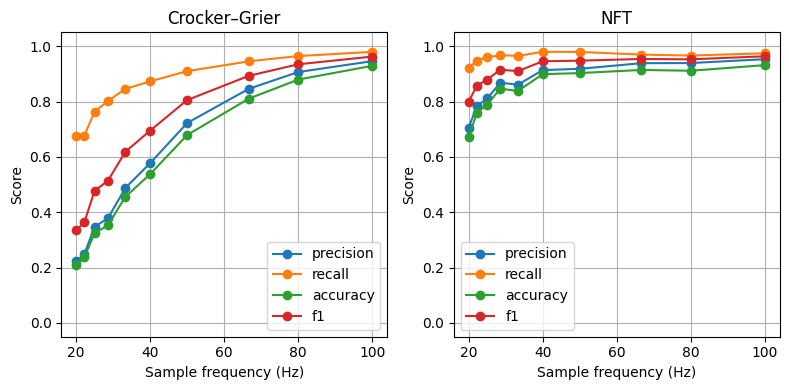

In [ ]:

f, a = plt.subplots(1, 2, figsize=(8, 4))
for i, stat_name in enumerate(['precision', 'recall', 'accuracy', 'f1']):
    a[0].plot(sample_frequency, scan_results['cv'][stat_name], 'o-', label=stat_name)
    a[1].plot(sample_frequency, scan_results['nft'][stat_name], 'o-', label=stat_name)
a[0].set_xlabel('Sample frequency (Hz)')
a[0].set_ylabel('Score')
a[0].legend()
a[0].set_ylim(-0.05, 1.05)
a[0].grid()
# a[0].set_xscale('log')
a[0].set_title('Crocker–Grier')
a[1].set_xlabel('Sample frequency (Hz)')
a[1].set_ylabel('Score')
a[1].legend()
# a[1].set_xscale('log')
a[1].set_ylim(-0.05, 1.05)
a[1].set_title('NFT')
a[1].grid()
plt.tight_layout()

In [103]:
fig_fp = os.path.join(vis_folder, f"tracking_algorithm_comparison.png")
io.print_image_in_several_formats(f, fig_fp)

Finish saving figure as /net/birdstore/Vessel/Lightfield/Tube2025/visualization/tracking_algorithm_comparison.pdf
Finish saving figure as /net/birdstore/Vessel/Lightfield/Tube2025/visualization/tracking_algorithm_comparison.pickle
Finish saving figure as /net/birdstore/Vessel/Lightfield/Tube2025/visualization/tracking_algorithm_comparison.png
